# International Mathematical Olympiad (IMO) Analysis 🧮

This week, for #tidytuesday, we are analyzing data from the International Mathematical Olympiad (IMO).

For data and a better intro than mine, go ➡️ [here](data/2024/2024-09-24/readme.md)

Here is a little bit about the IMO:

> The International Mathematical Olympiad (IMO) is the World Championship Mathematics Competition for High School students and is held annually in a different country. The first IMO was held in 1959 in Romania, with 7 countries participating. It has gradually expanded to over 100 countries from 5 continents. The competition consists of 6 problems and is held over two consecutive days with 3 problems each.

Many thanks to [Havisha Khurana](https://github.com/havishak) for putting the dataset together, and to [Emi Tanaka](https://github.com/emitanaka) for catching the bug in the original script!

In [1]:
## Importing Required Packages
using Pkg
Pkg.add(["CSV", "DataFrames", "DataFramesMeta", "HTTP", "Statistics", "StatsPlots", "Plots", "Chain"])

# Load the necessary packages
using CSV, DataFrames, DataFramesMeta, HTTP, Statistics, StatsPlots, Plots, Chain


   Resolving package versions...
  No Changes to `C:\Users\ndfos\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\ndfos\.julia\environments\v1.10\Manifest.toml`


## Loading Data from URLs
We'll load the datasets into DataFrames from their respective URLs.

I did find an issue with a recent commit of the data after the issue referenced above.  I found that `total` and `rank` were missing from the [data dictionary](https://github.com/rfordatascience/tidytuesday/data/2024/2024-09-24/readme.md) (these have been removed), check out the issue I submitted [here](https://github.com/rfordatascience/tidytuesday/issues/757#issue-2548792636) to see the solution I offer in R so you can get the country_results_df with the `total` and `rank` columns and answer the research questions as I do.  For this reason, the country file is pulled from my Github, all other manipulations are identical to the source.  Doing this is optional, and you can follow the available path via the #tidytuesday Github files that are available and that is just fine.  Jon Harmon and gang do an amazing job, not throwing shade their way at all.

In [2]:
# URLs for the CSV files

country_url = "https://raw.githubusercontent.com/nicolasfoss/tidy_tuesday/6d27ab32c81dc1a8a2857a5fcfcf0c3e2f219a83/International_Math_Olympiad_2024_09_24/country_results_df.csv"
individual_url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2024/2024-09-24/individual_results_df.csv"
timeline_url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2024/2024-09-24/timeline_df.csv"

# Reading the data into DataFrames
country_results_df = CSV.read(HTTP.get(country_url).body, DataFrame)
individual_results_df = CSV.read(HTTP.get(individual_url).body, DataFrame)
timeline_df = CSV.read(HTTP.get(timeline_url).body, DataFrame);

## Data Overview and Initial Exploration

## Next Steps
### Data Cleaning and Wrangling

We’ll clean the data, handle missing values, and set up relevant subsets for each goal. Let’s start by handling missing values in each dataset:

### Country Results Data
First, let's take a look at the structure and a sample of the `country_results_df`.

In [3]:
# Display the first few rows and structure of country_results_df
first(country_results_df, 5)  # first 5 rows

5×20 DataFrame
 Row │ year   country                     team_size_all  team_size_male  team_ ⋯
     │ Int64  String                      Int64          String3         Strin ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  2024  United States of America                6  5               1     ⋯
   2 │  2024  People's Republic of China              6  6               0
   3 │  2024  Republic of Korea                       6  6               0
   4 │  2024  India                                   6  6               0
   5 │  2024  Belarus                                 6  6               0     ⋯
                                                              16 columns omitted

In [4]:
# summary statistics
describe(country_results_df)

20×7 DataFrame
 Row │ variable                   mean     min         median  max             ⋯
     │ Symbol                     Union…   Any         Union…  Any             ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ year                       2003.91  1959        2006.0  2024            ⋯
   2 │ country                             Albania             Zimbabwe
   3 │ team_size_all              5.74233  1           6.0     8
   4 │ team_size_male                      0                   NA
   5 │ team_size_female                    0                   NA              ⋯
   6 │ p1                                  0                   NA
   7 │ p2                                  0                   NA
   8 │ p3                                  0                   NA
  ⋮  │             ⋮                 ⋮         ⋮         ⋮            ⋮        ⋱
  14 │ rank                                1                   NA              ⋯
  15 │ awards_gold                         0                   NA
  16 │ awards_silver                       0                   NA
  17 │ awards_bronze                       0                   NA
  18 │ awards_honorable_mentions           0                   NA              ⋯
  19 │ leader                              A. Barone           Željko Hanjš
  20 │ deputy_leader                       ? Soemirat          Željko Potkonja
                                                    3 columns and 5 rows omitted

## The score columns are strings...

...which could be helpful, potentially not depending on how we conduct our analyses later.

### The `leader` and `deputy_leader` columns have missing values.  Let's explore that.

Black cells are complete, gray cells are missing.

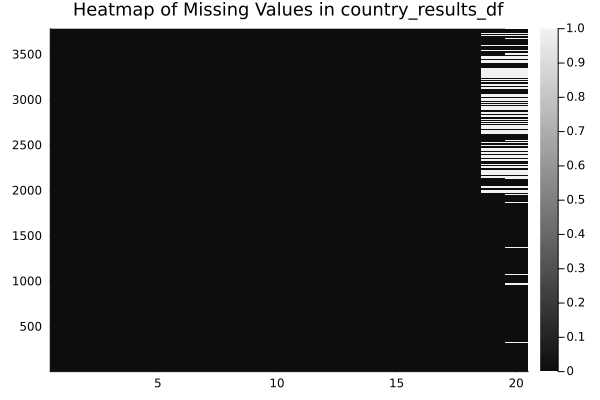

In [5]:
heatmap(
    Matrix(ismissing.(country_results_df)
    ),
    color = :grays,
    title = "Heatmap of Missing Values in country_results_df",
    titlefontsize = 12
)

## The missingness seems to have some structure 
This is problematic, and there seem to be some cases where values in both columns are missing together.  We will need to keep the missingness in mind later when we do further descriptive analyses.  In earlier years, it appears that fewer values were missing, and the missingness could have been missing at random (MAR).  Presently, there seems to be some structure in more recent years in the missingness, which may lead us to conclude that the data are missing not at random (MNAR).

### Let's view a subset of rows from these columns that have missing values

In [6]:
# leader column

first(
    country_results_df[ismissing.(country_results_df.leader), :], 
    5 # number of rows to view
)

5×20 DataFrame
 Row │ year   country      team_size_all  team_size_male  team_size_female  p1 ⋯
     │ Int64  String       Int64          String3         String3           St ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  2024  Bolivia                  4  3               1                 15 ⋯
   2 │  2024  El Salvador              3  2               1                 7
   3 │  2024  Nicaragua                1  1               0                 7
   4 │  2023  Cuba                     2  1               1                 9
   5 │  2022  Uruguay                  2  2               0                 13 ⋯
                                                              15 columns omitted

In [7]:
# deputy leader column
first(
    country_results_df[ismissing.(country_results_df.deputy_leader), :], 
    5 # number of rows to view
)

5×20 DataFrame
 Row │ year   country    team_size_all  team_size_male  team_size_female  p1   ⋯
     │ Int64  String     Int64          String3         String3           Stri ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  2024  Panama                 1  1               0                 3    ⋯
   2 │  2024  Honduras               1  1               0                 1
   3 │  2023  Peru                   6  6               0                 37
   4 │  2023  Uruguay                3  3               0                 21
   5 │  2023  Nicaragua              3  3               0                 12   ⋯
                                                              15 columns omitted

## Let's deal with columns that are not formatted correctly in `country_results_df`

#### Dropping or Filling Missing Data
After identifying missing / incorrectly formatted values, decide whether to drop rows with missing data or fill them with an appropriate value (e.g., zeros, mean).

It is clear that we will need to impute some missing values or change the format of some missing values.  Let's create a function to help.

In [8]:
# Define the function with type checking and error handling
function imo_impute(df::DataFrame, col::Symbol;
    not_value="NA", 
    impute_with=missing, 
    format=Int)
# Replace `not_value` with `impute_with` in the specified column
df[!, col]=replace(df[!, col], not_value => impute_with)

# parse the format of the new column
df[!, col] = passmissing(parse).(format, df[!, col])

return df  # Return the modified DataFrame

end

# get column names of interest

format_names = [:team_size_male, :team_size_female, :p1, :p2, :p3, :p4, :p5, :p6, :p7, :total, :rank, :awards_gold, :awards_silver, :awards_bronze, :awards_honorable_mentions]

country_results_clean = copy(country_results_df)

# reformat

for column in format_names

country_results_clean = imo_impute(country_results_clean, column)

end

In [9]:
# check columns for problems
describe(country_results_clean)

20×7 DataFrame
 Row │ variable                   mean      min         median  max            ⋯
     │ Symbol                     Union…    Any         Union…  Any            ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ year                       2003.91   1959        2006.0  2024           ⋯
   2 │ country                              Albania             Zimbabwe
   3 │ team_size_all              5.74233   1           6.0     8
   4 │ team_size_male             5.1996    0           6.0     8
   5 │ team_size_female           1.06625   0           1.0     6              ⋯
   6 │ p1                         24.7371   0           26.0    56
   7 │ p2                         15.4351   0           12.0    56
   8 │ p3                         6.95831   0           2.0     64
  ⋮  │             ⋮                 ⋮          ⋮         ⋮            ⋮       ⋱
  14 │ rank                       41.6159   1           37.5    112            ⋯
  15 │ awards_gold                0.470619  0           0.0     6
  16 │ awards_silver              0.960296  0           0.0     6
  17 │ awards_bronze              1.41715   0           1.0     6
  18 │ awards_honorable_mentions  1.17703   0           1.0     6              ⋯
  19 │ leader                               A. Barone           Željko Hanjš
  20 │ deputy_leader                        ? Soemirat          Željko Potkonj
                                                    3 columns and 5 rows omitted

### Missing leaders and deputy leaders?

There are cases where there is no team leader but there is a deputy leader, and there are also cases where there is a leader and no deputy leader.  This seems to make sense given that a competitor could get sick, injured, etc.  Shouldn't that person still be listed, though?

These problems could lead us to need to further look at contextual information about the data to understand this, and this could affect our inferences about future statistical analyses.

## Individual Results Data

In [10]:
# Display the first few rows and structure of individual_results_df
first(individual_results_df, 5)

5×13 DataFrame
 Row │ year   contestant          country                     p1       p2      ⋯
     │ Int64  String              String                      String3  String3 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  2024  Haojia Shi          People's Republic of China  7        7       ⋯
   2 │  2024  Ivan Chasovskikh    C21                         7        7
   3 │  2024  Alexander Wang      United States of America    7        7
   4 │  2024  Satoshi Kano        Japan                       7        7
   5 │  2024  László Bence Simon  Hungary                     7        7       ⋯
                                                               8 columns omitted

In [11]:
# summary statistics
describe(individual_results_df)

13×7 DataFrame
 Row │ variable         mean     min           median  max            nmissing ⋯
     │ Symbol           Union…   Any           Union…  Any            Int64    ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ year             2003.01  1959          2006.0  2024                  0 ⋯
   2 │ contestant                *                     Žiga Oštir            0
   3 │ country                   Albania               Zimbabwe              0
   4 │ p1                        0                     NA                    0
   5 │ p2                        0                     NA                    0 ⋯
   6 │ p3                        0                     NA                    0
   7 │ p4                        0                     NA                    0
   8 │ p5                        0                     NA                    0
   9 │ p6                        0                     NA                    0 ⋯
  10 │ p7                        0                     NA                    0
  11 │ total            15.9824  0             15.0    46                    0
  12 │ individual_rank           1                     NA                    0
  13 │ award                     Bronze medal          Special prize      7044 ⋯
                                                                1 column omitted

### Let's see a subset of rows where the `award` is missing.

In [12]:
# view some missing rows from award

first(
    individual_results_df[ismissing.(individual_results_df.award), :],
    5 # number of rows to view
)

5×13 DataFrame
 Row │ year   contestant                  country       p1       p2       p3   ⋯
     │ Int64  String                      String        String3  String3  Stri ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  2024  Juan José Martínez Barreto  Venezuela     5        0        0    ⋯
   2 │  2024  Matic Pogorelec             Slovenia      6        0        0
   3 │  2024  Youkyum Kim                 South Africa  4        2        0
   4 │  2024  Jonas Boeykens              Belgium       6        1        0
   5 │  2024  Hashir Naimat               Pakistan      6        0        0    ⋯
                                                               8 columns omitted

## Again, scores as strings...

Let's go ahead and deal with that.

In [13]:
# get names to format from the individual_results_df dataset
format_names2 = [:p1, :p2, :p3, :p4, :p5, :p6, :p7, :individual_rank]

# create a new df
individual_results_clean = copy(individual_results_df)

# iterate over columns with the custom function

for column in format_names2

    individual_results_clean = imo_impute(individual_results_clean, column)

end

In [14]:
# check for any problems

describe(individual_results_clean)

13×7 DataFrame
 Row │ variable         mean      min           median  max            nmissin ⋯
     │ Symbol           Union…    Any           Union…  Any            Int64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ year             2003.01   1959          2006.0  2024                   ⋯
   2 │ contestant                 *                     Žiga Oštir
   3 │ country                    Albania               Zimbabwe
   4 │ p1               4.35995   0             6.0     8                  109
   5 │ p2               2.71219   0             1.0     8                  109 ⋯
   6 │ p3               1.20501   0             0.0     9                  109
   7 │ p4               4.05918   0             5.0     7                  109
   8 │ p5               2.45629   0             1.0     8                  109
   9 │ p6               0.972106  0             0.0     9                  109 ⋯
  10 │ p7               2.0       0             1.0     8                 2168
  11 │ total            15.9824   0             15.0    46
  12 │ individual_rank  219.879   1             189.0   604                  2
  13 │ award                      Bronze medal          Special prize      704 ⋯
                                                               2 columns omitted

### Missing values within the `award` column seem to be related to people that just didn't get a medal.

This makes sense and would be expected.  Let's view the missingness in this dataset via a heatmap below.

Let black cells equal complete values, and those that are gray represent missing values.

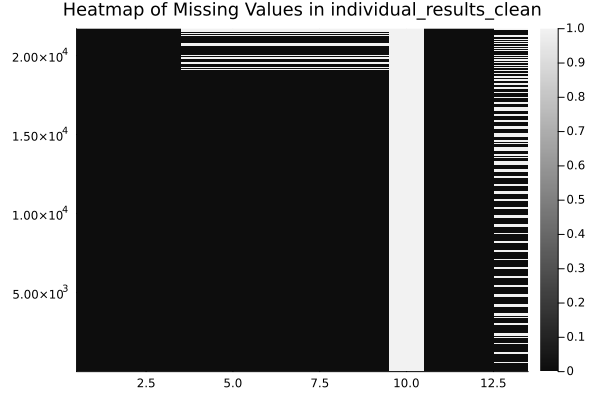

In [15]:
# award column 

heatmap(
    Matrix(
        ismissing.(individual_results_clean)
        ), 
        color=:grays,
        title = "Heatmap of Missing Values in individual_results_clean",
        titlefontsize = 12
)

### Missingness gets more prevalent over time

The rows at the bottom of the dataframe are older records, and the records at the top are newer based on what we saw earlier.
This shows us that for some reason, these data were complete more often in the past than they are now, and the missingness seems to be systematic with some form of seasonality or (more likely) a cyclical trend.

## Timeline Data

In [16]:
# Display the first few rows and structure of timeline_df
first(timeline_df, 5)

5×10 DataFrame
 Row │ edition  year   country             city                                ⋯
     │ Int64    Int64  String              String                              ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │      65   2024  United Kingdom      Bath                                ⋯
   2 │      64   2023  Japan               Chiba
   3 │      63   2022  Norway              Oslo
   4 │      62   2021  Russian Federation  A distributed IMO administered f…
   5 │      61   2020  Russian Federation  A distributed IMO administered f…   ⋯
                                                               6 columns omitted

In [17]:
# summary statistics
describe(timeline_df)

10×7 DataFrame
 Row │ variable           mean     min                                median   ⋯
     │ Symbol             Union…   Any                                Any      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ edition            33.0     1                                  33.0     ⋯
   2 │ year               1991.68  1959                               1992.0
   3 │ country                     Argentina                                  
   4 │ city                        A distributed IMO administered f…          
   5 │ countries          58.0154  5                                  56.0     ⋯
   6 │ all_contestant     333.692  39                                 322.0
   7 │ male_contestant    279.877  32                                 277.0
   8 │ female_contestant           1                                          
   9 │ start_date                  1959-07-21                         1992-07- ⋯
  10 │ end_date                    1959-07-31                         1992-07-
                                                               4 columns omitted

### Interesting, no missingness!

This dataset is complete, which is helpful, and the format of the values makes sense so far.

We have a problem with one variable, `female_contestant` which we need to fix.  Let's do this one more time!

In [18]:
# new dataset

timeline_clean = copy(timeline_df)

# clean

timeline_clean = imo_impute(timeline_clean, :female_contestant);

In [19]:
# check for issues

describe(timeline_clean)

10×7 DataFrame
 Row │ variable           mean     min                                median   ⋯
     │ Symbol             Union…   Any                                Any      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ edition            33.0     1                                  33.0     ⋯
   2 │ year               1991.68  1959                               1992.0
   3 │ country                     Argentina                                  
   4 │ city                        A distributed IMO administered f…          
   5 │ countries          58.0154  5                                  56.0     ⋯
   6 │ all_contestant     333.692  39                                 322.0
   7 │ male_contestant    279.877  32                                 277.0
   8 │ female_contestant  26.7031  1                                  21.0
   9 │ start_date                  1959-07-21                         1992-07- ⋯
  10 │ end_date                    1959-07-31                         1992-07-
                                                               4 columns omitted

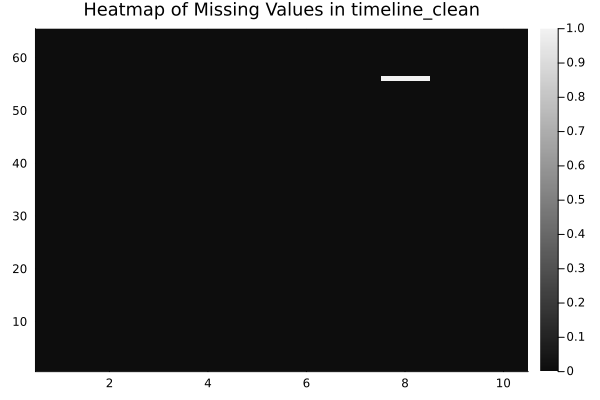

In [20]:
# visualize the missingness

heatmap(
    Matrix(ismissing.(timeline_clean)),
    color = :grays,
    title = "Heatmap of Missing Values in timeline_clean",
    titlefontsize = 12
)

## Analysis Goals
We'll explore the following:

* Shifts in country rankings over time: How do country rankings evolve?
* Gender distribution: What are the gender participation trends?
* Distribution of top scores: Who scores the highest?
* Relationship between team size and country performance: Does a larger team mean better results?
* Relationship between team composition and country performance: Do first-time participants or veterans impact results differently?

### Visualizing Country Rankings Over Time

We will create a line plot showing how the rank of each country has changed over the years.

In [21]:
# How many countries are there?
println("There are ", 
length(unique(country_results_df.country)),
" unique countries in the country_results_df dataset."
)

There are 139 unique countries in the country_results_df dataset.


### Visualizing Country Rankings Over Time

We will create a line plot showing how the rank of each country has changed over the years.

First we need to manipulate the data a bit to get it to do what we want.

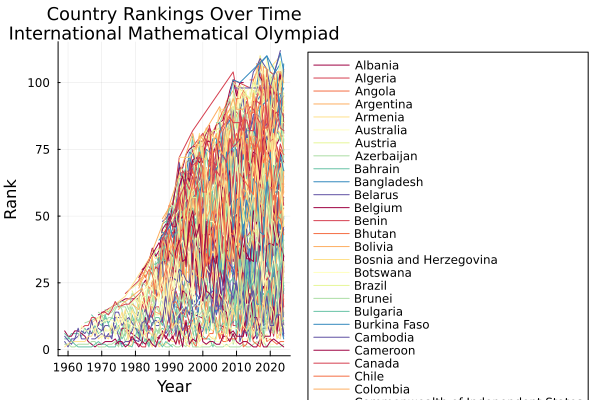

In [98]:
# the reason we need to do that, is visualizing the rankings over time would be a nightmare, observe:

@df country_results_clean plot(:year, :rank, 
group=:country, 
palette=:Spectral, 
title="Country Rankings Over Time\nInternational Mathematical Olympiad", 
xlabel="Year", 
ylabel="Rank", 
legend=:outertopright, 
titlefontsize=12
)

### We can improve upon that, but first a little work.

In [74]:
# add the chain package for readability
Pkg.add("Chain")
using Chain

   Resolving package versions...
   Installed Chain ─ v0.6.0
    Updating `C:\Users\ndfos\.julia\environments\v1.10\Project.toml`
  [8be319e6] + Chain v0.6.0
    Updating `C:\Users\ndfos\.julia\environments\v1.10\Manifest.toml`
  [8be319e6] + Chain v0.6.0
Precompiling project...
  ✓ Chain
  1 dependency successfully precompiled in 3 seconds. 259 already precompiled.


In [108]:

# Step 1: Filter out rows where `rank` is missing, then get the sum of `rank == 1` by country
first_place_counts = @chain begin 
    country_results_clean
    dropmissing(:rank)  # Step 1: Remove rows with missing rank
    filter(row -> row.rank == 1, _)  # Apply filter to the dataframe passed through the chain, "_" refers to the dataframe we pass
    groupby(:country)  # Group by country
    combine(:rank => length => :first_place_count)  # Count first-place finishes
end

# Step 2: Sort countries by the number of first-place ranks and keep the top 5
top_5_countries = 
@chain begin 
    first_place_counts
    sort(:first_place_count, rev=true)
    first(5)
end

# Step 3: Extract the names of the top 10 countries
top_5_country_names = top_5_countries.country

# Step 4: Filter the main dataset for only these top 10 countries
top_5_country_results = @chain begin
    country_results_clean_no_missing
    filter(:country => (x -> x in top_5_country_names), _)
end

# check our work
describe(top_5_country_results, :mean, :std, :min, :nunique, :nmissing, :nnonmissing, :first, :last, :eltype)

20×10 DataFrame
 Row │ variable                   mean      std       min           nunique  n ⋯
     │ Symbol                     Union…    Union…    Any           Union…   I ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ year                       1993.47   18.2656   1959                     ⋯
   2 │ country                                        Hungary       5
   3 │ team_size_all              6.45344   1.01456   2                     
   4 │ team_size_male             6.05668   1.12475   2                     
   5 │ team_size_female           0.852941  0.465679  0                        ⋯
   6 │ p1                         37.2627   7.42619   6                     
   7 │ p2                         33.8341   11.0156   0                     
   8 │ p3                         24.5945   14.3075   0                     
  ⋮  │             ⋮                 ⋮         ⋮           ⋮           ⋮       ⋱
  14 │ rank                       6.02429   6.77929   1                        ⋯
  15 │ awards_gold                2.37652   1.85882   0                     
  16 │ awards_silver              2.25101   1.34714   0                     
  17 │ awards_bronze              1.24696   1.2263    0                     
  18 │ awards_honorable_mentions  0.119205  0.398784  0                        ⋯
  19 │ leader                                         A. P. Savin   52
  20 │ deputy_leader                                  Alex Saltman  68
                                                    5 columns and 5 rows omitted

In [145]:
# Check out the top 5 countries with the most first Placements
top_5_countries

5×2 DataFrame
 Row │ country                            first_place_count 
     │ String                             Int64             
─────┼──────────────────────────────────────────────────────
   1 │ People's Republic of China                        24
   2 │ Union of Soviet Socialist Republ…                 14
   3 │ United States of America                           9
   4 │ Hungary                                            6
   5 │ Romania                                            5

### Create the line plot

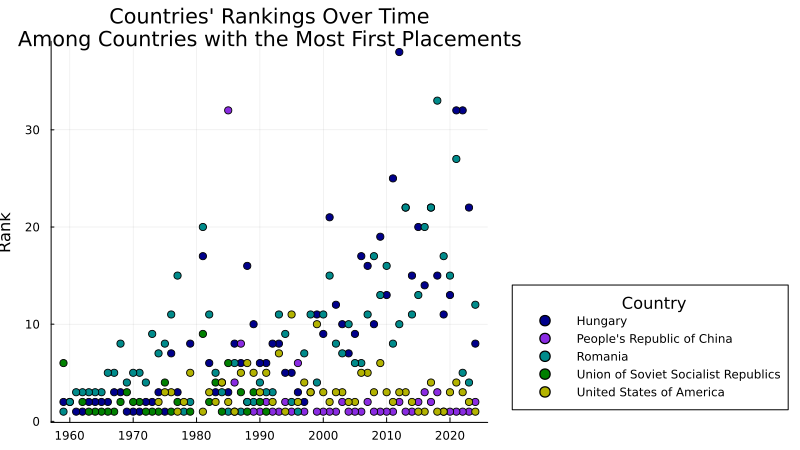

In [144]:
# Step 5: Plot rank over time for the top 10 countries
@df top_10_country_results scatter(:year, :rank, group=:country, 
    xlabel="", ylabel="Rank", 
    title="Countries' Rankings Over Time\nAmong Countries with the Most First Placements",
    lw=3, palette=:darktest,
    legend=:outerbottomright, legendtitle = "Country",
    size=(800, 450))

### Gender Distribution Over Time

We’ll create a simple line plot showing the number of male and female participants each year.

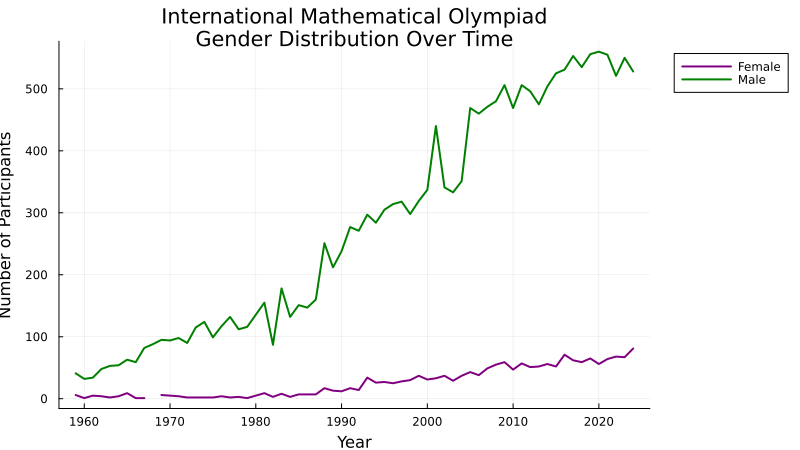

In [66]:
# Gender distribution: Summing male and female participants per year
gender_distribution = combine(groupby(timeline_clean, :year), 
    :male_contestant => sum => :male_sum, 
    :female_contestant => sum => :female_sum)

    gender_distribution_pivot = stack(gender_distribution, [:male_sum, :female_sum], :year)

# Plotting gender distribution over time
@df gender_distribution_pivot plot(:year, 
    :value, group=:variable, 
    xlabel="Year", ylabel="Number of Participants", 
    label=["Female" "Male"], 
    title="International Mathematical Olympiad\nGender Distribution Over Time", 
    lw=2, legend=:outertopright, size=(800,450), palette=[:purple, :green],
    titlefontfize = 12
    )



### Interesting, female participation has slowly but steadily increased, while male participation has taken significant dips.

It may take the ladies a while to catch up, but they are steadily becoming a greater part of these competitions.

### Who is on the scoreboard?  Let's look at top scores

As expected, the distribution of scores is right skewed toward the smaller subset of individuals with exceptional performance.

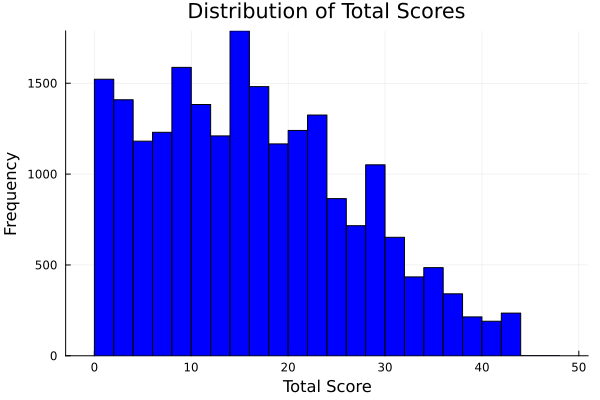

In [149]:
# Histogram of top scores from individual results
@df individual_results_clean histogram(:total, 
    bins=30, xlabel="Total Score", ylabel="Frequency", 
    title="Distribution of Total Scores", 
    legend=false, color=:blue)

## Top Scoring Participants (Bar Chart)

We will now create a bar chart of the top scoring participants, sorted in descending order, and flip the chart to make the names easier to read.


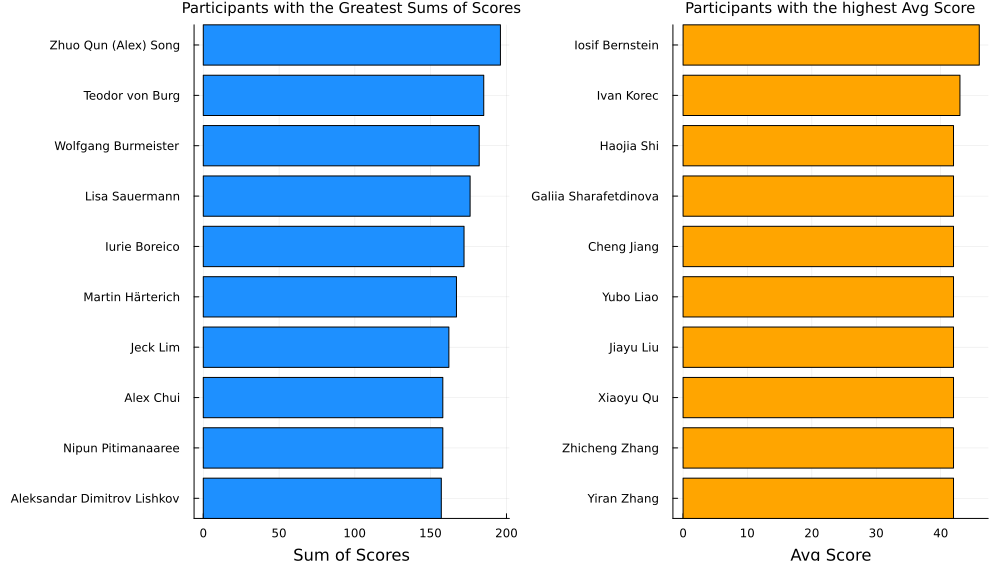

In [186]:
# Step 1: Get summary statistics on participants
top_scorers = @chain individual_results_clean begin
    filter(row -> !(row.contestant in ["*", "?"]), _)  # Filter out contestants with names "*" or "?"
    groupby(:contestant)
    combine( 
        :total => mean => :Avg_Score,   # Calculate average score
        :total => sum => :Total_Points,   # Calculate total points
        :year => length => :N_Competitions  # Count unique years competed
    )
end

# Step 2: Create a flipped bar charts of top scorers
top_scorers_total = @chain begin top_scorers
    sort(:Total_Points, rev=true)  # Sort by total score in descending order
    first(10)  # Select the top 10 scoring participants
    end
    
    # create the first bar chart illustrating total points (i.e. participation!)
    top_score_total_bar = @df top_scorers_total bar(:contestant, :Total_Points, permute=(:x, :y), 
        ylabel="Sum of Scores", xlabel="", 
        title="Participants with the Greatest Sums of Scores", 
        legend=false, titlefontsize=10, color=:dodgerblue, size=(800, 450))
    yflip!()
    
    # create the second illustrating the mean (i.e. performance if multiple showings)
    top_scorers_avg = @chain begin top_scorers
        sort(:Avg_Score, rev=true)  # Sort by total score in descending order
        first(10)  # Select the top 10 scoring participants
        end
        
        # create the first bar chart illustrating total points (i.e. participation!)
        top_score_avg_bar = @df top_scorers_avg bar(:contestant, :Avg_Score, permute=(:x, :y), 
            ylabel="Avg Score", xlabel="", 
            title="Participants with the highest Avg Score", 
            legend=false, titlefontsize=10, color=:orange, size=(1000, 561))
        yflip!()
    
    bar_plots = [top_score_total_bar top_score_avg_bar]
    
    plot(bar_plots..., layout=(1,2))

### The tenacity award doesn't always get the win!

Here we see that average scores and sum of scores do not reflect the same individuals.

There are some individuals that have participated many multiple times over the years, but the average score may be a better measure of the quality of the player.

Observe below the number of people that have played multiple years!  Do you see any in the left bar chart above?

In [187]:
# view the tenacity award winners

@chain begin top_scorers
    sort(:N_Competitions, rev=true)
end

14719×4 DataFrame
   Row │ contestant                         Avg_Score  Total_Points  N_Competi ⋯
       │ String                             Float64    Int64         Int64     ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │ Yeoh Zi Song                         20.0              140            ⋯
     2 │ David Kunszenti-Kovács               18.7143           131
     3 │ Tan Li Xuan                          18.1667           109
     4 │ Zhuo Qun (Alex) Song                 32.6667           196
     5 │ Teodor von Burg                      30.8333           185            ⋯
     6 │ Alexey Entin                         23.1667           139
     7 │ Alex Chui                            31.6              158
     8 │ Damjan Davkov                        24.4              122
   ⋮   │                 ⋮                      ⋮           ⋮              ⋮   ⋱
 14713 │ Rafail Zlatarov                      19.0               19            ⋯
 14714 │ Tsvetana Penkovska                   15.0               15
 14715 │ Gyula Katona                         15.0               15
 14716 │ Aleksander Chetajev                  15.0               15
 14717 │ Ljubozar Dimitrov                    10.0               10            ⋯
 14718 │ Nedka Ivanova                         9.0                9
 14719 │ Todor Todorov                         8.0                8
                                                 1 column and 14704 rows omitted

## Team Size Analysis

We will analyze how team size relates to overall country performance.

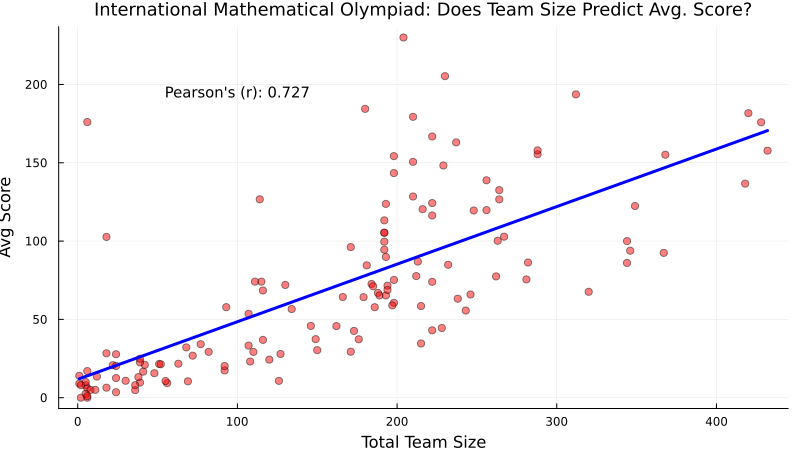

In [240]:
# Step 1: Summarize total scores and team size by country
team_size_analysis = @chain country_results_clean begin
    groupby(:country)
    combine(_, 
        :total => mean => :Avg_Score,   # Total score for the country
        :team_size_all => sum => :Total_Team_Size;  # Total number of contestants
        ungroup=true
    )
    dropmissing(:Avg_Score) # must remove the 1 missing value here to get regression line
end

# Step 2: Calculate Pearson's r for Total Team Size and Avg Score
pearsons_r = round(cor(team_size_analysis.Total_Team_Size, team_size_analysis.Avg_Score), digits=3)

# Step 3: Create a scatter plot to visualize the relationship
@df team_size_analysis scatter(:Total_Team_Size, :Avg_Score,
    xlabel="Total Team Size", ylabel="Avg Score",
    title="International Mathematical Olympiad: Does Team Size Predict Avg. Score?",
    legend=false, smooth=true, size=(800, 450), markercolor=:red,
    linealpha=1, markeralpha=0.5, linewidth=3, linecolor=:blue,
    titlefontsize=12
)
annotate!([(100, 200, text("Pearson's (r): " * string(pearsons_r), 10, :black, :top))])

In [266]:
# we need a dataframe with the country each participant corresponds to
country_participants = unique(individual_results_clean[:, [:country, :contestant]]);

## Team Composition Analysis

We will analyze how the composition of first-time participants versus veterans relates to overall country performance.


In [358]:
# Step 1: Summarize total scores and team composition by contestant
participant_types = @chain individual_results_clean begin
    filter(row -> !(row.contestant in ["*", "**", "*** ***", "?"]), _)  # Filter out contestants with names "*" or "?"
    groupby(:contestant)
    @combine(:Cumulative_Participation = length(:year); ungroup=true)  # Create a cumulative count
    @transform(:Participant_Type = ifelse.(:Cumulative_Participation .> 1, "Veteran", "Novice"))
    sort(:Cumulative_Participation, rev=true)
    leftjoin(country_participants, on=:contestant)
    groupby(:country)
    @combine(:Veteran_Count = sum(:Participant_Type .== "Veteran"),
             :Novice_Count = sum(:Participant_Type .== "Novice")
    )
    @transform(:Veteran_Ratio = :Veteran_Count ./ :Novice_Count
                                    )
end

first(participant_types, 5)

5×4 DataFrame
 Row │ country                     Veteran_Count  Novice_Count  Veteran_Ratio 
     │ String?                     Int64          Int64         Float64       
─────┼────────────────────────────────────────────────────────────────────────
   1 │ People's Republic of China             16           199       0.080402
   2 │ C21                                     0             1       0.0
   3 │ United States of America               78           135       0.577778
   4 │ Japan                                  48            90       0.533333
   5 │ Hungary                               109           163       0.668712

In [355]:
# explore counts of Team_Type groups

@chain begin participant_types
    groupby(:Team_Type)
    combine(:Team_Type => length => :n)
    @transform(:percent = string.(round.(:n / sum(:n) * 100, digits=2), "%"))
end

3×3 DataFrame
 Row │ Team_Type  n      percent 
     │ String     Int64  String  
─────┼───────────────────────────
   1 │ Novices      138  87.9%
   2 │ Veterans      17  10.83%
   3 │ Balance        2  1.27%

### Interesting, there are mostly teams that have a majority of novices

Novices have only played only once, whereas veterans have played greater than 1 year.

A country is designated as "novices" if they have mostly novice players, and "veterans" if they have mostly veteran players.

Let's explore

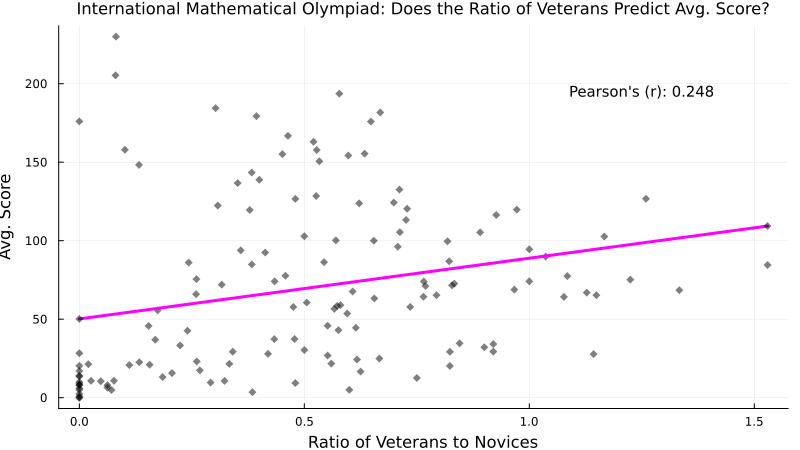

In [378]:
# Step 2: Count total first-time participants and veterans for each country
team_composition_analysis = @chain country_results_clean begin
    groupby(:country)
    combine(:total => mean => :Avg_Score, 
        :team_size_all => sum => :Total_Team_Size,  # Total team size for the country
        :awards_gold => sum => :Total_Gold_Awards,   # Total gold awards
        :awards_silver => sum => :Total_Silver_Awards,  # Total silver awards
        :awards_bronze => sum => :Total_Bronze_Awards,  # Total bronze awards
        :awards_honorable_mentions => sum => :Total_Honorable_Mentions  # Total honorable mentions
    )
    # Join with first_time_participants to include first-time counts
    leftjoin(_, participant_types, on=:country)
    # Filter out rows where Avg_Score is missing
    filter(row -> !ismissing(row.Avg_Score), _)
end

# Step 3: Calculate Pearson's r for the Veteran Ratio
pearsons_r_composition = round(
    cor(team_composition_analysis.Veteran_Ratio, team_composition_analysis.Avg_Score), 
    digits=3
    )

# Step 4: Create a scatter plot for First-Time Participants vs. Total Score
composition_scatter = @df team_composition_analysis scatter(:Veteran_Ratio, :Avg_Score,
    xlabel="Ratio of Veterans to Novices", ylabel="Avg. Score",
    title="International Mathematical Olympiad: Does the Ratio of Veterans Predict Avg. Score?",
    legend=false, smooth=true, size=(800, 450), marker=:diamond,
    markeralpha=0.5, markercolor=:black, linecolor=:magenta, linewidth=3,
    titlefontsize=11
)
annotate!([(1.25, 200, text("Pearson's (r): " * string(pearsons_r_composition), 10, :black, :top))])



## Conclusion

We found out a few things:

* There are some countries that have obtained top rank several times, but their trends of staying at the top ranks vary widely.

*  Players that have accumulated more points over time, or who have played numerous tournaments do not necessarily have the highest average score over time.

* Males greatly overtake females in terms of sheer counts, and male participation is growing rapidly.  However, female participation has continued to grow and has experienced less severe drops in participation as compared to males.  Females have experienced a steady, but slow, growth rate in their representation at the IMO.

* Team size seems to be strongly correlated with the average score a country achieves.

* The ratio of veterans to novices on a team does not seem to necessarily predict higher average scores.

Thanks for hannging with me!  Please let me know how we can improve this analysis / script.